In [76]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [98]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sqlalchemy import func, distinct



# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [80]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [81]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [82]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [83]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement

# the station class to a variable called `Station`
Station = Base.classes.station


In [84]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [90]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_row[0]
most_recent_date

'2017-08-23'

In [93]:
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

last_12_months = most_recent_date - timedelta(days=365)
last_12_months

datetime.datetime(2016, 8, 23, 0, 0)

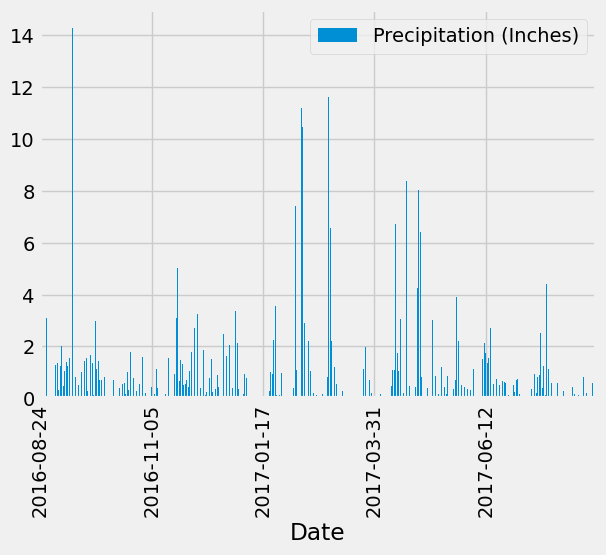

In [94]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
last_12_months = most_recent_date - timedelta(days=365)
last_12_months

# Perform a query to retrieve the data and precipitation scores
date_prcp = [Measurement.date, Measurement.prcp]

year_precipitation = session.query(*date_prcp).filter(Measurement.date>= last_12_months).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(year_precipitation, columns=["Date", "Precipitation (Inches)"])

# # Sort the dataframe by date
# precip_df initially gave me all of the precipitation info with multiple precipitation measurements per day, I get the total here
precip_totals_df = precip_df.groupby('Date')['Precipitation (Inches)'].sum().reset_index()

# Use Pandas Plotting with Matplotlib to plot the data
precip_totals_df.set_index('Date', inplace=True)
precip_chart = precip_totals_df.plot.bar()
xticks = range(0, len(precip_totals_df.index), 73)  # adjusted to 73 so the x-ticks will only show 5 dates out of the year for visibility
precip_chart.set_xticks(xticks)

plt.show()

In [95]:
# Use Pandas to calculate the summary statistics for the precipitation data
# this shows summary stats for each instance of precipitation
summary_stats = precip_df.describe()
summary_stats

,Precipitation (Inches)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [96]:
# summary stats above is the answer that was given, however, I also did summary_stats_total below to show the summary stats per day

summary_stats_total = precip_totals_df.describe()
summary_stats_total

,Precipitation (Inches)
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [99]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(func.count(distinct(Measurement.station))).scalar()
number_of_stations

9

In [100]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(
    Measurement.station,
    func.count(Measurement.station)
).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [101]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
most_active_station_temps

[(54.0, 85.0, 71.66378066378067)]

In [102]:
#double checking the information this yields before turning it into a bar chart
station_temps = session.query(Measurement.tobs,func.count(Measurement.tobs)).filter(Measurement.date>= last_12_months).filter(Measurement.station == "USC00519281").group_by(Measurement.tobs).order_by(Measurement.tobs.asc()).all()
station_temps

[(59.0, 3),
 (60.0, 2),
 (61.0, 1),
 (62.0, 6),
 (63.0, 4),
 (64.0, 3),
 (65.0, 7),
 (66.0, 5),
 (67.0, 15),
 (68.0, 12),
 (69.0, 19),
 (70.0, 22),
 (71.0, 18),
 (72.0, 22),
 (73.0, 18),
 (74.0, 39),
 (75.0, 33),
 (76.0, 33),
 (77.0, 30),
 (78.0, 22),
 (79.0, 18),
 (80.0, 11),
 (81.0, 4),
 (82.0, 3),
 (83.0, 1)]

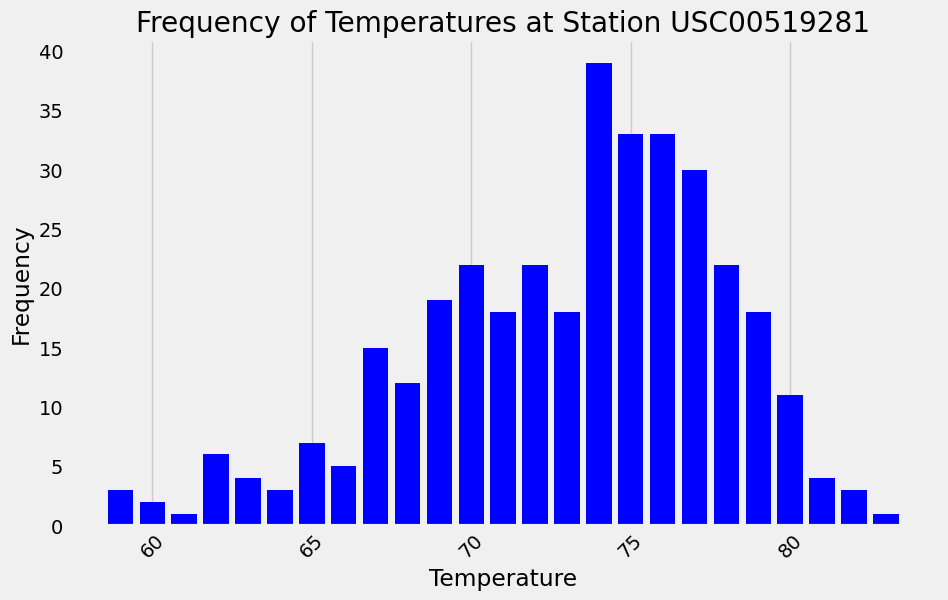

In [103]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(Measurement.tobs,func.count(Measurement.tobs)).filter(Measurement.date>= last_12_months).filter(Measurement.station == "USC00519281").group_by(Measurement.tobs).order_by(Measurement.tobs.asc()).all()

#convert into a dataframe after checking above this yielded the correct results
df_station_temps = pd.DataFrame(station_temps, columns=["Temperature", "Frequency"])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(df_station_temps["Temperature"], df_station_temps["Frequency"], color='blue')
plt.title('Frequency of Temperatures at Station USC00519281')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels if necessary
plt.grid(axis='y')
plt.show()


# Close Session

In [104]:
# Close Session
session.close()
